# Scattering for Emission Spectra

Here we describe the scattering implementation of pRT. It is based on the implementation of [petitCODE](https://www2.mpia-hd.mpg.de/~molliere/code/), which is described in detail in Section 3.2 of [this PhD thesis](http://www.ub.uni-heidelberg.de/archiv/23252).

## Self-scattering in gas giants

Self-scattering is important to consider for (cloudy) brown dwarfs and directly imaged planets. It can also be imortant for transiting planets, however, for example when considering the emission from their likely cloudy night sides. Self-scattering means that photons originating in the planetary atmosphere will be scattered. The reference for self-scattering in pRT is [Mollière et al. (2020)](https://arxiv.org/abs/2006.09394).

To turn on scattering one must simply pass the keyword ``scattering_in_emission = True`` to ``Radtrans()`` when initializing the pRT object. Here we will take the setup similar to the example described in ["Clouds"](./including_clouds.ipynb), considering a Mg$_2$SiO$_4$ cloud.

In [1]:
import numpy as np
import pylab as plt

plt.rcParams['figure.figsize'] = (10, 6)
from petitRADTRANS.radtrans import Radtrans
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.physics import temperature_profile_function_guillot_global

# Load scattering version of pRT
atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      cloud_species = ['Mg2SiO4(s)_crystalline__DHS'],
                      wavelength_boundaries = [0.3, 15],
                      scattering_in_emission=True)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Users/molliere/Desktop/input_data_v3/inp

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive), and the mean molecular mass in atomic mass units. They will be converted to cgs units within the code.
</div>

Next we define the atmosphere, and some cloud parameters. Again, see the ["Clouds"](./including_clouds.ipynb) page for more information. The parameters are chosen more appropriately for a directly imaged object, specifically by also setting $T_{\rm eq}=0$. **Note that these are freely made up values, however. The P-T profile of a real directly imaged planet may well be different (e.g., likely not isothermal at low pressures). Also the abundances are just made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](./interpolating_chemical_equilibrium_abundances.ipynb) for how to improve this  <span style="color:red">CHECK LINK</span>). We set the cloud mass fraction to be zero for pressures larger than 3 bar in this example, which is the location of our hypothetical cloud base. The cloud mass fraction is taken to decrease $\propto P^{f_{\rm sed}}$ above the cloud base here, where $P$ is the pressure and $f_{\rm sed}$ the settling parameter, so as to account for the settling of cloud particles, as motivated by the [Ackerman & Marley (2001) cloud model](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..872A/abstract). In principle any other vertical profile can be chosen here. Also, a more realistic setup may place the cloud base at the location where the P-T curve and the saturation vapor pressure curve of a given cloud species intersect.

In [2]:
R_pl = 1.2*cst.r_jup_mean
reference_gravity = 1e1**3.5

# P-T parameters
pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 1200.
T_equ = 0.
temperature = temperature_profile_function_guillot_global(pressures_bar,
                                                          kappa_IR, gamma,
                                                          reference_gravity,
                                                          T_int,
                                                          T_equ)

# Cloud parameters
eddy_diffusion_coefficients = np.ones_like(temperature)*1e1**6.5
cloud_f_sed = {}
cloud_f_sed['Mg2SiO4(s)_crystalline__DHS'] = 2.
cloud_particle_radius_distribution_std = 1.05

# Absorber mass fractions
mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO-NatAbund'] = 0.005 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.000001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.0000001 * np.ones_like(temperature)
mass_fractions['Na'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K'] = 0.000001 * np.ones_like(temperature)

# Cloud mass fractions
mass_fractions_cloud = np.zeros_like(temperature)
mass_fractions_cloud[pressures_bar<=3.] = 0.00005 * (pressures_bar[pressures_bar<=3.]/3.)**cloud_f_sed['Mg2SiO4(s)_crystalline__DHS']
mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = mass_fractions_cloud

mean_molar_masses = 2.33 * np.ones_like(temperature)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** remember that abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the mass of a single molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

This is the P-T profile we are using for our simple setup:

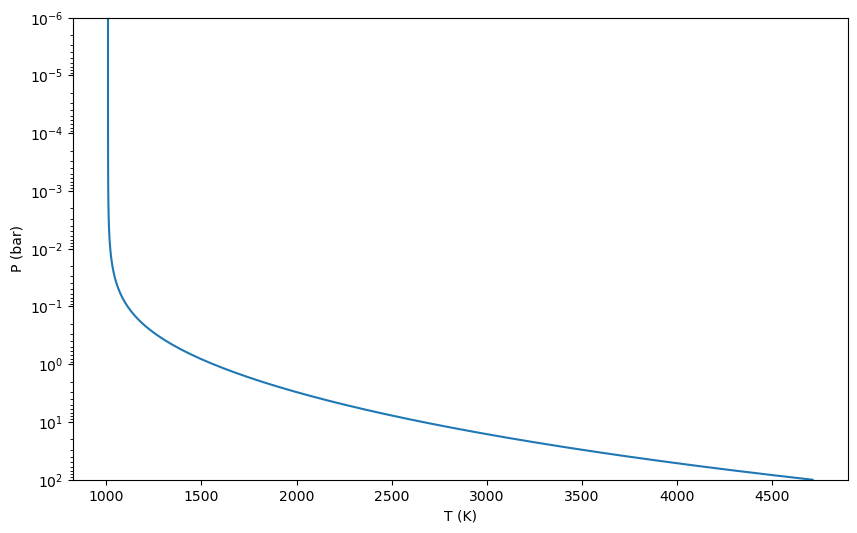

<Figure size 1000x600 with 0 Axes>

In [3]:
plt.plot(temperature, pressures_bar)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

We will also compare to the cloud-free case, and the case neglecting scattering again. For the last case we have to initialize a pRT object with ``do_scat_emis = False``, or omit the ``do_scat_emis`` keyword altogether when initializing the pRT object.

In [4]:
atmosphere_no_scat = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      cloud_species = ['Mg2SiO4(s)_crystalline__DHS'],
                      wavelength_boundaries = [0.3, 15],
                      scattering_in_emission=False)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Users/molliere/Desktop/input_data_v3/inp

Now we will plot the spectra for the three cases, including scattering, neglecting scattering, and turning off the clouds. In addition, we set ``return_contribution = True`` in the ``calculate_flux()`` methods, such that we can study the contribution functions of the cases below. See ["Analysis Tools"](./analysis_tools.ipynb) (<span style="color:red">CHECK LINK</span>) for more information on emission contribution functions.

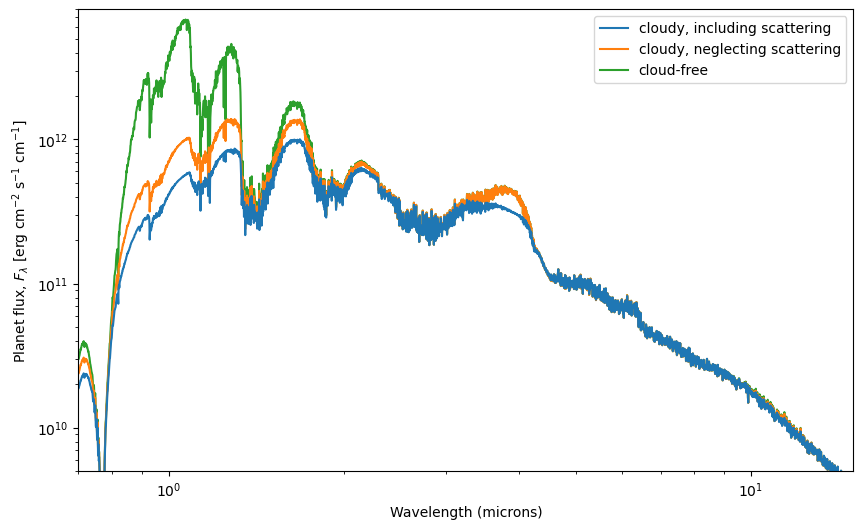

<Figure size 1000x600 with 0 Axes>

In [5]:
mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = mass_fractions_cloud

wavelengths, flux, additional_returned_quantities = atmosphere.calculate_flux(temperatures=temperature, 
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          eddy_diffusion_coefficients=eddy_diffusion_coefficients,
                          cloud_f_sed=cloud_f_sed,
                          cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
                          return_contribution=True)

plt.plot(wavelengths*1e4, flux, label = 'cloudy, including scattering', zorder = 2)
contribution_scattering = additional_returned_quantities['emission_contribution']

wavelengths, flux, additional_returned_quantities = atmosphere_no_scat.calculate_flux(temperatures=temperature, 
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          eddy_diffusion_coefficients=eddy_diffusion_coefficients,
                          cloud_f_sed=cloud_f_sed,
                          cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
                          return_contribution=True)

plt.plot(wavelengths*1e4, flux, label = 'cloudy, neglecting scattering', zorder = 1)
contribution_no_scattering = additional_returned_quantities['emission_contribution']

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(mass_fractions_cloud)

wavelengths, flux, additional_returned_quantities = atmosphere_no_scat.calculate_flux(temperatures=temperature, 
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          eddy_diffusion_coefficients=eddy_diffusion_coefficients,
                          cloud_f_sed=cloud_f_sed,
                          cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
                          return_contribution=True)

plt.plot(wavelengths*1e4, flux, label = 'cloud-free', zorder = 0)
contribution_clear = additional_returned_quantities['emission_contribution']

plt.legend(loc='best')
plt.xlim([0.7, 15])
plt.ylim([5e9, 0.8e13])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')
plt.show()
plt.clf()

<div class="alert alert-warning">

**Standard flux units:** before pRT3 flux was accessed as `atmosphere.flux` after running `atmosphere.calc_flux()`, which contained flux as $F_\nu$, so in units of erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$. pRT's `calculate_flux()` method now returns wavelength and flux as $F_\lambda$ in its standard setting, so flux in erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$. To return frequencies and $F_\nu$, instead of wavelengths and $F_\lambda$, please set the keyword `frequencies_to_wavelengths=False` when calling `calculate_flux().`

</div>

Finally, we compare the emission contribution of the cloudy (with scattering) and clear case below. The cloud deck at 3 bar is clearly visible in the contribution function for the cloudy case, as it is cutting off the emission from the atmosphere between 2 and 3 bar.

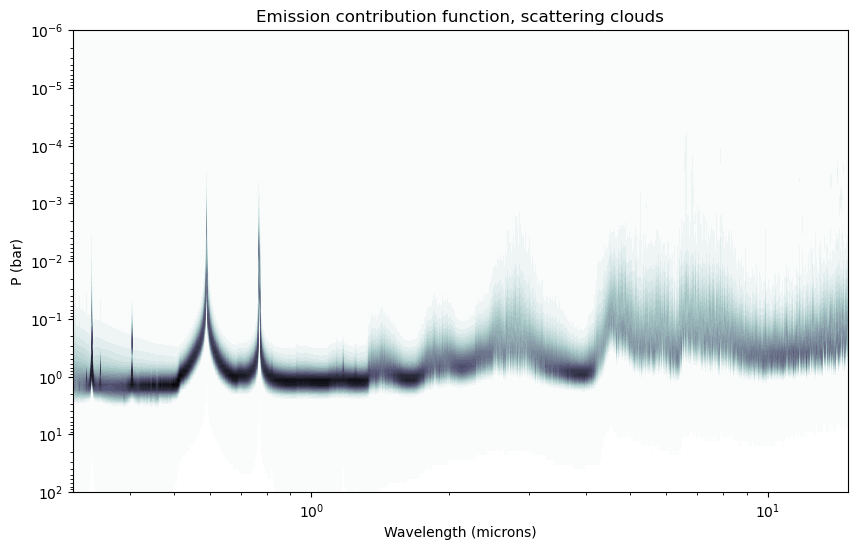

<Figure size 1000x600 with 0 Axes>

In [6]:
wlen_mu = wavelengths*1e4
X, Y = np.meshgrid(wlen_mu, pressures_bar)
plt.contourf(X,Y,contribution_scattering,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function, scattering clouds')
plt.show()
plt.clf()

In contrast, no clouds hide the deep hot regions from view in the clear case, allowing for pressures of multiple 10s of bars being probed in the optical.

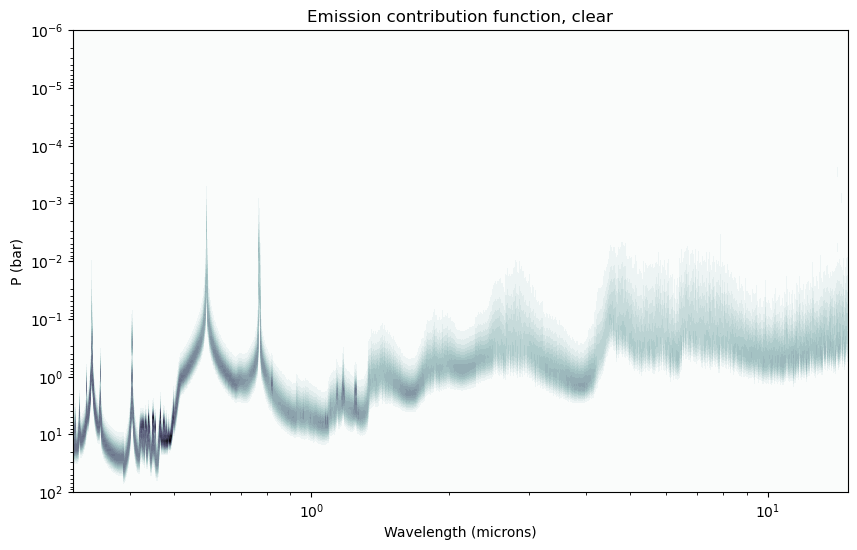

<Figure size 1000x600 with 0 Axes>

In [7]:
plt.contourf(X,Y,contribution_clear,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function, clear')
plt.show()
plt.clf()

## Scattering of stellar light

For the optical and near-infrared spectra of close-in planets, scattering of stellar light can be important. We likewise ported this implementation from [petitCODE](https://www2.mpia-hd.mpg.de/~molliere/code/) and verified the pRT results with petitCODE calculations. Together with the newly added surface scattering for terretrial planets, this is described in detail in [Alei et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...665A.106A/abstract). For the planetary insolation, stellar spectra will be interpolated from the available PHOENIX/ATLAS9 spectra (see [Utility Functions](./utility_functions.ipynb) section). To control the insolation flux contribution, a few more arguments are required when calling the ``calculate_flux()`` method. These are:


* ``emission_geometry``: the geometry and dilution of the incoming stellar radiation field (see below for further information);
* ``star_effective_temperature``: the stellar effective temperature in K;
* ``star_radius``: the stellar radius in cm; if you don't specify a radius, pRT will take the stellar radius at 1/3 of the main sequence life time of star with the specified effective temperature, see [van Boekel et al. (2012)](http://adsabs.harvard.edu/abs/2012SPIE.8442E..1FV). To specify your own radius (recommended when comparing to actual observations) you can use the ``physical_constants`` module or pRT to import constants in cgs (e.g., `as cst`, as done above); ``cst.r_sun`` is the solar radius in cm. This is also done in the examples below.
* ``orbit_semi_major_axis``: the distance of the planet from the star in cm. Again, you can use the ``physical_constants`` module to import constants in cgs, ``cst.au`` is the astronomical unit in cm.


## Geometries

The scattering of direct stellar light can be treated considering different geometries, specifiying the direction of the incoming stellar irradiation, and its absolute flux value. pRT offers three scenarios:

* the globally-averaged insolation (``emission_geometry = planetary_ave``), that assumes that the stellar radiation reaches the atmosphere isotropically from above, and that its flux value is the average received over the full surface area of the planet. This translates into multiplying the stellar flux by a factor 1/4.
* the dayside-averaged insolation (``emission_geometry = dayside_ave``), that assumes that the stellar radiation reaches the atmosphere isotropically and is the average received over the dayside of the planet. This translates into multiplying the stellar flux by a factor 1/2.
* the non-isotropic case (``emission_geometry = non-isotropic``) which assumes that the stellar radiation comes from a specific direction, with respect to the atmospheric normal vector. The angle between the incoming stellar light and the atmospheric normal, $\vartheta_* \in [0,90^\circ]$, must be provided by the user with ``star_irradiation_angle`` parameter. For example, an angle of $0^\circ$ means that the star is irradiating the atmosphere from directly overhead (this is the substellar point).

Here we define an example atmosphere of a hot Jupiter-like planet, irradiated by its host star. See ["Clouds"](./including_clouds.ipynb) for more information on how to chose these input parameters.

In [8]:
planet_radius = 1.838*cst.r_jup_mean
reference_gravity = 1e1**2.45
reference_pressure = 0.01

pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO-NatAbund'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K'] = 0.000001 * np.ones_like(temperature)

mean_molar_masses = 2.33 * np.ones_like(temperature)

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = mass_fractions_cloud

This is what the P-T profile looks like:

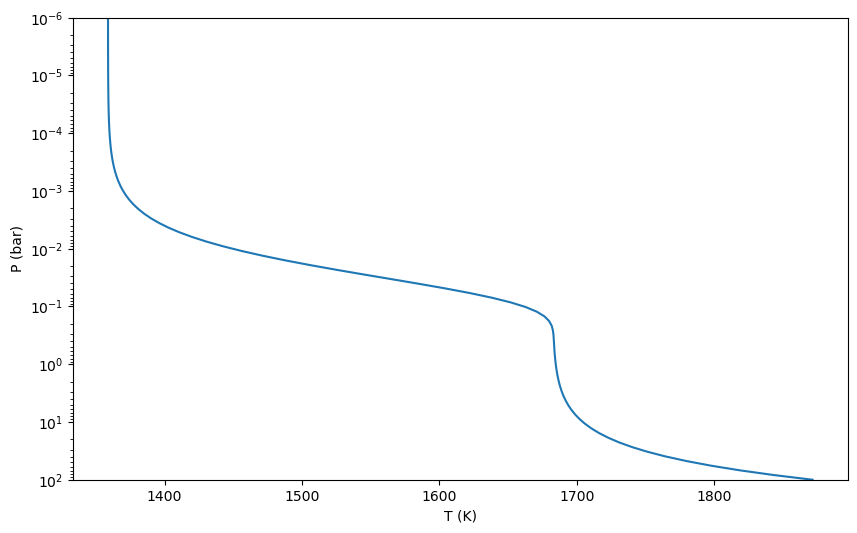

In [9]:
plt.plot(temperatures, pressures_bar)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()

We can then compare the emission spectra considering the three geometries.
As ``scattering_in_emission = True``, these calculations will both contain the scattering of the stellar and the self-scattering of the planetary light.

<div class="alert alert-warning">

In the following we set `frequencies_to_wavelengths=False`, different from the treatment above. So `calculate_flux()` will return frequencies and $F_\nu$ in units of erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$, instead of wavelengths and $F_\lambda$.

</div>

Loading PHOENIX star table in file '/Users/molliere/Desktop/input_data_v3/input_data/stellar_spectra/phoenix/phoenix.startable.petitRADTRANS.h5'... Done.


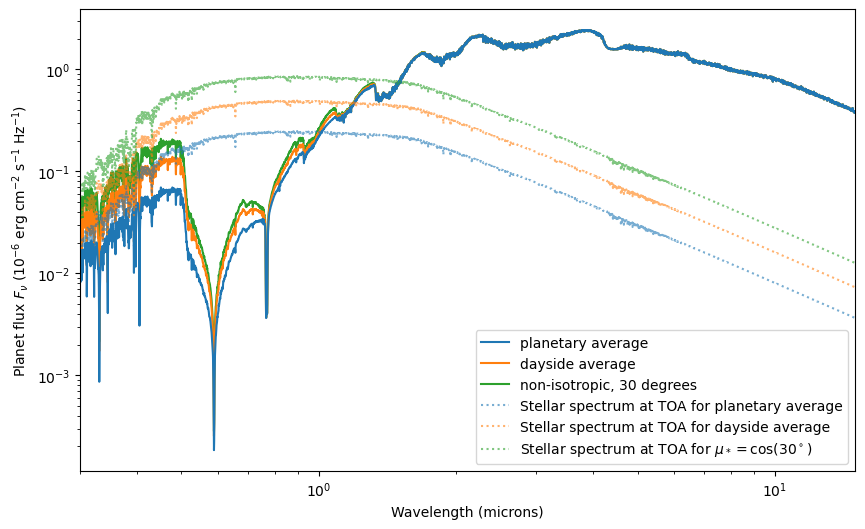

In [10]:
frequencies, flux, _ = atmosphere.calculate_flux(temperatures=temperatures, 
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          eddy_diffusion_coefficients=eddy_diffusion_coefficients,
                          cloud_f_sed=cloud_f_sed,
                          cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
                          emission_geometry='planetary_ave',
                          star_effective_temperature=5778,
                          star_radius=cst.r_sun,
                          orbit_semi_major_axis=0.05*cst.au,
                          frequencies_to_wavelengths=False)

plt.plot(cst.c/frequencies/1e-4,
         flux/1e-6,
         label = 'planetary average',
         zorder=2)

frequencies, flux, _ = atmosphere.calculate_flux(temperatures=temperatures, 
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          eddy_diffusion_coefficients=eddy_diffusion_coefficients,
                          cloud_f_sed=cloud_f_sed,
                          cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
                          emission_geometry='dayside_ave',
                          star_effective_temperature=5778,
                          star_radius=cst.r_sun,
                          orbit_semi_major_axis=0.05*cst.au,
                          frequencies_to_wavelengths=False)

plt.plot(cst.c/frequencies/1e-4,
         flux/1e-6,
         label = 'dayside average',
         zorder=1)


frequencies, flux, additional_outputs = atmosphere.calculate_flux(temperatures=temperatures, 
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          eddy_diffusion_coefficients=eddy_diffusion_coefficients,
                          cloud_f_sed=cloud_f_sed,
                          cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
                          emission_geometry='non-isotropic',
                          star_irradiation_angle = 30.,
                          star_effective_temperature=5778,
                          star_radius=cst.r_sun,
                          orbit_semi_major_axis=0.05*cst.au,
                          frequencies_to_wavelengths=False)

plt.plot(cst.c/frequencies/1e-4,
         flux/1e-6,
         label = 'non-isotropic, 30 degrees',
         zorder=0)

plt.plot(cst.c/frequencies/1e-4,
         additional_outputs['stellar_intensities']/4.*np.pi/1e-6,
         label = r'Stellar spectrum at TOA for planetary average',alpha=0.6,
         color = 'C0', linestyle = ':')

plt.plot(cst.c/frequencies/1e-4,
         additional_outputs['stellar_intensities']/2.*np.pi/1e-6,
         label = r'Stellar spectrum at TOA for dayside average',alpha=0.6,
         color = 'C1', linestyle = ':')

plt.plot(cst.c/frequencies/1e-4,
         additional_outputs['stellar_intensities']*np.cos(30./180.*np.pi)*np.pi/1e-6,
         label = r'Stellar spectrum at TOA for $\mu_*={\rm cos}(30^\circ)$',alpha=0.6,
         color = 'C2', linestyle = ':')

plt.legend(loc='best')  
plt.xlim([0.3, 15])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (microns)')  
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')  
plt.show()

We also plotted the stellar flux scaled at the top of the atmosphere for comparison using the `stellar_intensity` attribute. As this is an intensity we have to multiply it by $\pi$ to transform it to flux units. Furthermore we need to multiply the resulting flux by 1/4 to be consistent with the planetary average geometry. For the dayside average the multiplying factor is 1/2, whereas for an incidence angle of $\vartheta_*$ the factor is $\mu_* = {\rm cos}\vartheta_*$. *For convenience during plotting we already multiply this value by $(R_*/d)^2$ inside pRT, where $R_*$ is the stellar radius and $d$ the distance between planet and star.*

## Surface scattering

For smaller exoplanets with thin atmospheres, the surface may contribute to the emission spectrum. In the non-scattering version of pRT the surface emits like a blackbody. Here we explain how pRT can be used to also include the scattering of light at the planetary surface, which will is described in detail in [Alei et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...665A.106A/abstract). In addition to the reflectivity of the surface (aka surface albedo), also the emissivity can be defined. The surface scattering is assumed to be an isotropic, that is, Lambertian process.

To start, let's define an Earth-like planet neglecting clouds. We assume a ground pressure of 1 bar which results in an atmosphere thin enough to not absorb all of the radiation emitted and scattered by the surface. We also include O3 here, please note that the [HITRAN](https://hitran.org) line lists we use for O$_3$ are limited to the NIR/MIR range (excluding the UV). The P-T profile for our simple example is chosen to lead to roughly the right temperatures as observed for Earth's atmosphere, neglecting the temperature version of its stratospheric region.

In [11]:
# Load scattering version of pRT
atmosphere = Radtrans(pressures = np.logspace(-6,0,100),
                      line_species = ['H2O', 
                                      'CH4', 
                                      'CO2', 
                                      'O3'],
                      rayleigh_species = ['N2', 'O2'],
                      gas_continuum_contributors = ['N2-N2', 'N2-O2','O2-O2','CO2-CO2'],
                      wavelength_boundaries = [0.3, 15],
                      scattering_in_emission=True)

planet_radius = cst.r_earth 
reference_gravity = cst.G*(cst.m_earth)/planet_radius**2 

# P-T parameters 
pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.0009
gamma = 0.01 
T_int = 250. 
T_equ = 220. 

temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ)

# Mean molecular weight of Earth's atmosphere
mean_molar_masses = 28.7 * np.ones_like(temperatures)

# Absorber mass fractions
volume_mixing_ratios = {}
volume_mixing_ratios['N2'] = 0.78 * np.ones_like(temperatures)
volume_mixing_ratios['O2'] = 0.21 * np.ones_like(temperatures)
volume_mixing_ratios['H2O'] = 0.001 * np.ones_like(temperatures)
volume_mixing_ratios['O3'] = 1e-7 * np.ones_like(temperatures)
volume_mixing_ratios['CO2'] = 0.0004 * np.ones_like(temperatures)
volume_mixing_ratios['CH4'] = 0.0001 * np.ones_like(temperatures)

from petitRADTRANS.chemistry.utils import volume_mixing_ratios2mass_fractions

mass_fractions = volume_mixing_ratios2mass_fractions(volume_mixing_ratios, mean_molar_masses=mean_molar_masses)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'O3' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/O3/16O3/16O3__HITRAN.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for N2-N2 from file '/Users/molliere/Desktop/input_dat

Note that we used `volume_mixing_ratios2mass_fractions()` to convert from volume mixing ratios to mass fractions here, which is what is needed by pRT.

This is the P-T profile we are using for our simple setup:

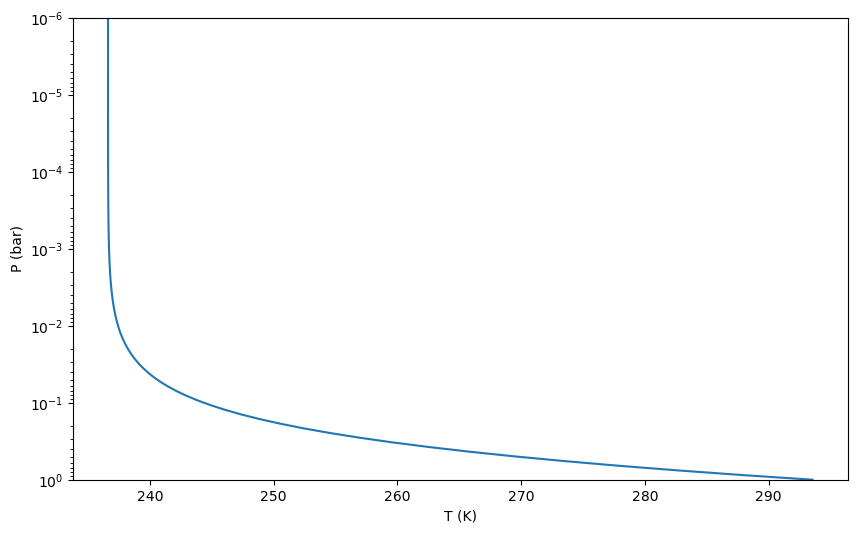

<Figure size 1000x600 with 0 Axes>

In [12]:
plt.plot(temperatures, pressures_bar)
plt.yscale('log')
plt.ylim([1e0, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

By default, the highest pressure (lowest altitude) layer of the atmosphere will always be treated as the location of the surface of the planet by pRT. This is no hindrance when calculating the spectra of gas giant planets, as long as we chose the largest pressure deep enough, such that the surface never becomes visible.

As the planetary surface is visible in our case here, it makes sense to vary a few extra variables: the reflectance and the emissivity of the surface. The reflectance determines the fraction of light that is scattered back from the surface layer; the emissivity determines the fraction of thermal radiation emitted by the surface when compared to a blackbody.

It is possible to change the value of the surface reflectance and of the surface emissivity by filling it with an array with as many elements as the wavelengths/frequencies considered by pRT. In this way, wavelength-dependent reflectance / emissivity values can be considered. Constant values of reflectivity and emissivity can be also considered by filling the array with the same value.
The default values of reflectance and emissivity (i.e., if you don't provide any values for them) are 0 and 1, respectively.  

In this example, we vary the surface reflectance of a cloud-free Earth-like planet, orbiting a Sun-like star at 1 AU, with a planetary-averaged insolation redistribution. 

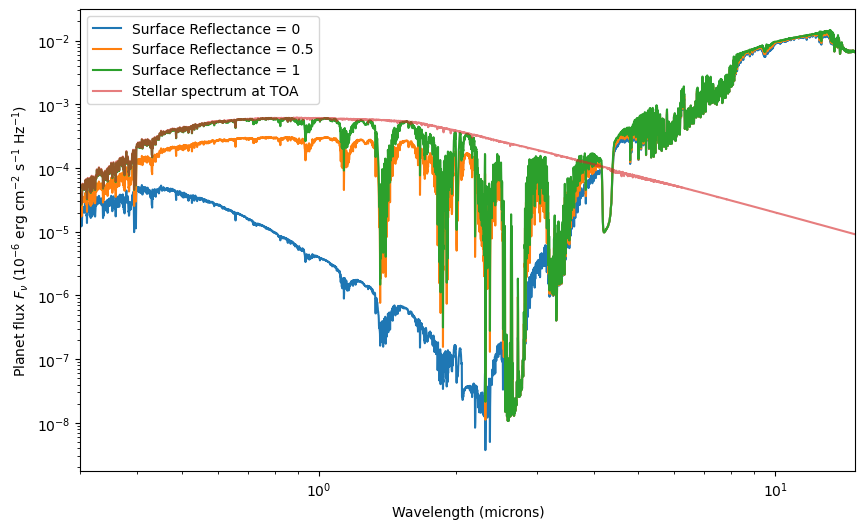

In [13]:
for r in [0,0.5,1]:
    
    reflectances = r * np.ones_like(atmosphere._frequencies)

    frequencies, flux, additional_outputs = atmosphere.calculate_flux(temperatures=temperatures,
                                                                      mass_fractions=mass_fractions, 
                                                                      mean_molar_masses=mean_molar_masses, 
                                                                      reference_gravity=reference_gravity,
                                                                      emission_geometry='planetary_ave',
                                                                      star_effective_temperature=5778,
                                                                      star_radius=cst.r_sun,
                                                                      orbit_semi_major_axis=1.0*cst.au,
                                                                      reflectances=reflectances,
                                                                      frequencies_to_wavelengths=False)

    plt.semilogy(cst.c/frequencies/1e-4, flux/1e-6,
             label = 'Surface Reflectance = '+str(r), zorder = 2)
    
plt.semilogy(cst.c/frequencies/1e-4, additional_outputs['stellar_intensities']/4.*np.pi/1e-6, \
             label = 'Stellar spectrum at TOA',alpha=0.6)
    
plt.legend(loc='best')
plt.xlim([0.3, 15])
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()

We can also get the emission spectra of this atmosphere assuming a more Earth-like surface reflectivity (average value of 0.3 up to 3 $\mu m$, 0 in the IR).

In [14]:
reflectances = [0.3 if l<=3. else 0 for l in cst.c/atmosphere._frequencies/1e-4]

frequencies, flux, additional_outputs = atmosphere.calculate_flux(temperatures=temperatures,
                                                                  mass_fractions=mass_fractions, 
                                                                  mean_molar_masses=mean_molar_masses, 
                                                                  reference_gravity=reference_gravity,
                                                                  emission_geometry='planetary_ave',
                                                                  star_effective_temperature=5778,
                                                                  star_radius=cst.r_sun,
                                                                  orbit_semi_major_axis=1.0*cst.au,
                                                                  reflectances=reflectances,
                                                                  frequencies_to_wavelengths=False)

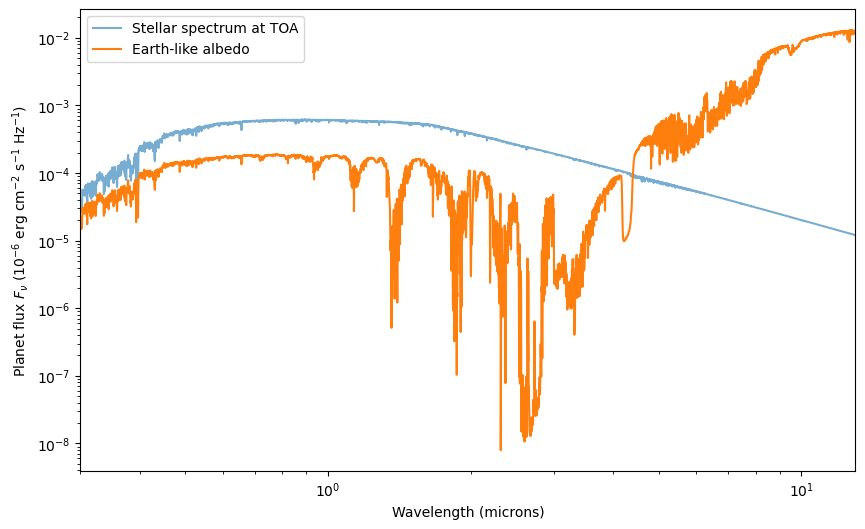

In [15]:
plt.semilogy(cst.c/frequencies/1e-4, additional_outputs['stellar_intensities']/4.*np.pi/1e-6, \
             label = 'Stellar spectrum at TOA',alpha=0.6)
plt.semilogy(cst.c/frequencies/1e-4, flux/1e-6, \
             label = 'Earth-like albedo', zorder = 2)

    
plt.legend(loc='best')
plt.xlim([0.3, 13.])
plt.xscale('log')


plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()



Finally here an example for a surface reflectivity of 1, as a function of different incidence angles.

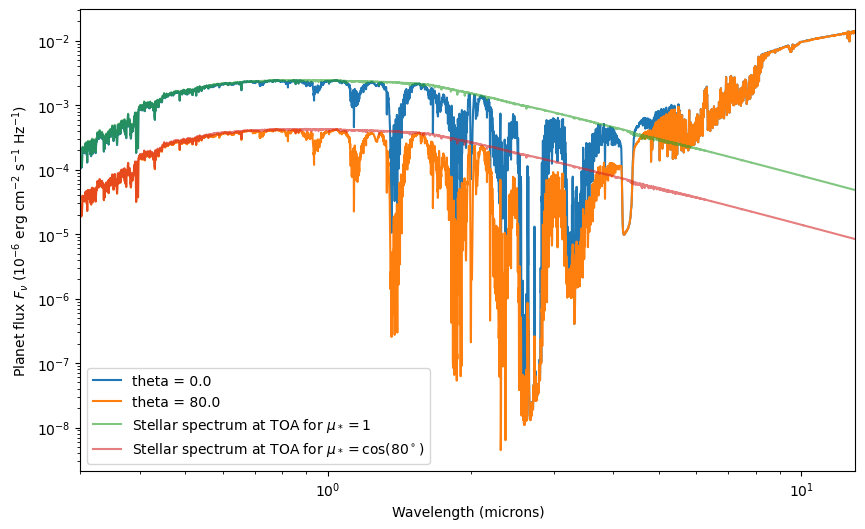

In [16]:
reflectances = np.ones_like(atmosphere._frequencies)

thetas = [0., 80.]

for theta in thetas:

    frequencies, flux, additional_outputs = atmosphere.calculate_flux(temperatures=temperatures, 
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          emission_geometry='non-isotropic',
                          star_irradiation_angle = theta,
                          star_effective_temperature=5778,
                          star_radius=cst.r_sun,
                          orbit_semi_major_axis=1.0*cst.au,
                          frequencies_to_wavelengths=False,
                          reflectances=reflectances)
    
    plt.semilogy(cst.c/frequencies/1e-4, flux/1e-6, \
             label = 'theta = '+str(theta), zorder = 2)

plt.semilogy(cst.c/frequencies/1e-4, additional_outputs['stellar_intensities']*np.pi/1e-6, \
             label = r'Stellar spectrum at TOA for $\mu_*=1$',alpha=0.6)

plt.semilogy(cst.c/frequencies/1e-4, additional_outputs['stellar_intensities']*np.cos(80./180.*np.pi)*np.pi/1e-6, \
             label = r'Stellar spectrum at TOA for $\mu_*={\rm cos}(80^\circ)$',alpha=0.6)

plt.legend(loc='best')
plt.xlim([0.3, 13.])
plt.xscale('log')


plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()